# Image recognition Wetterskip Fryslan #

De opdracht is om op lucht-/satellietfoto's water te onderscheiden van land. Hiermee zou het waterschap geautomatiseerd veranderingen in de waterstand kunnen detecteren.

### Aanpak ###

Van een satellietfoto worden tegels gemaakt die dienen als de trainingsdata voor een classifier. 

Van dezelfde foto in zwart (water)/ wit (geen water) worden labels (water, oever, land gemaakt). 

### Functies, Import en Globale variabelen ###

In [1]:
def sliding_window(image, stepSize, windowSize):
	# slide a window across the image
	for y in range(0, image.shape[0], stepSize):
		for x in range(0, image.shape[1], stepSize):
			# yield the current window
			yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

def tegelen(image,size):
    # per rij tegels van grootte size maken
    RowLen = image.shape[0]
    ColLen = image.shape[1]
    return np.array([image[x:x+size,y:y+size] for x in range(0, RowLen,size) for y in range(0, ColLen,size)])

def myshow(nda, title=None, margin=0.05, dpi=80):
    #SimpleITK code not needed for OpenCV
    #nda = sitk.GetArrayViewFromImage(img)
    #spacing = img.GetSpacing()
    spacing=[]
    spacing.append(nda.shape[0])
    spacing.append(nda.shape[1])  
        
    if nda.ndim == 3:
        # fastest dim, either component or x
        c = nda.shape[-1]
        
        # the the number of components is 3 or 4 consider it an RGB image
        if not c in (3,4):
            nda = nda[nda.shape[0]//2,:,:]
    
    elif nda.ndim == 4:
        c = nda.shape[-1]
        
        if not c in (3,4):
            raise Runtime("Unable to show 3D-vector Image")
            
        # take a z-slice
        nda = nda[nda.shape[0]//2,:,:,:]
            
    ysize = nda.shape[0]
    xsize = nda.shape[1]
      
    # Make a figure big enough to accommodate an axis of xpixels by ypixels
    # as well as the ticklabels, etc...
    figsize = (1 + margin) * ysize / dpi, (1 + margin) * xsize / dpi

    fig = plt.figure(figsize=figsize, dpi=dpi)
    # Make the axis the right size...
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])
    
    extent = (0, xsize*spacing[1], ysize*spacing[0], 0)
    
    t = ax.imshow(nda,extent=extent,interpolation=None)
    
    if nda.ndim == 2:
        t.set_cmap("gray")
    
    if(title):
        plt.title(title)
        
def hog(img):
    bin_n = 9
    gx = cv2.Sobel(img, cv2.CV_32F, 1, 0)
    gy = cv2.Sobel(img, cv2.CV_32F, 0, 1)
    mag, ang = cv2.cartToPolar(gx, gy)
    bins = np.int32(bin_n*ang/(2*np.pi))    # quantizing binvalues in (0...9)
    bin_cells = bins[:10,:10], bins[10:,:10], bins[:10,10:], bins[10:,10:]
    mag_cells = mag[:10,:10], mag[10:,:10], mag[:10,10:], mag[10:,10:]
    hists = [np.bincount(b.ravel(), m.ravel(), bin_n) for b, m in zip(bin_cells, mag_cells)]
    hist = np.hstack(hists)     # hist is a 36 values vector
    return hist

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import ndimage as ndi
from itertools import chain
import pandas as pd

import cv2

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.preprocessing import Normalizer

## Preprocessing ##

### Feature extraction ###
http://www.learnopencv.com/histogram-of-oriented-gradients/ 

https://docs.opencv.org/trunk/dd/d3b/tutorial_py_svm_opencv.html

Inlezen image. Omzetten naar Histogram of Oriented Gradient als feature vector.

Image van 1000x1000 in tegels van 20x20. HOG met 36 values. Vervolgen normalizeren.

Dan labels toevoegen aan de 2500 featurevectoren. Zwart is water (=0). Wit is land (=255, na omzetten 1).

In [48]:
img_rgb = cv2.imread('water.tif')

# Verdeel plaatje in delen van 20x20
z = 20
tegels_rgb = tegelen(img_rgb,z)

# Maak HOG aan voor elke tegel. Elke tegel krijgt een factor van 36
hogdata=[]
for tegel in tegels_rgb:
    hogdata.append(hog(tegel))

In [49]:
# Labels
img_lab = cv2.imread('water_labels.tif')

#verdeel image in vierkante tegels met zijde z
tegels_lab = tegelen(img_lab,z)

#Labels omzetten naar: 1.0 = Land, 0.0 = Water. Alles er tussen is oever.
labels = [(np.mean(x))/255 for x in tegels_lab]

In [50]:
# Naar pandas Dataframe om alleen land en water rijen over te houden.
tf_df = pd.DataFrame(hogdata)

tf_df['label'] = labels

In [51]:
#Alleen Land en Water overhouden.
tf_df.drop(tf_df[(tf_df.label < 1.0) & (tf_df.label > 0.0)].index, inplace=True)

#zorg voor evenredige verdeling land en water in de dataset
nroWater = len(tf_df[tf_df['label'] == 0])
nroLand  = len(tf_df[tf_df['label'] == 1])
if  nroWater < nroLand:
    land_df = tf_df[tf_df['label'] == 1].sample(nroWater)
    data_df = tf_df[tf_df['label'] == 0].append(land_df)
else:
    water_df = tf_df[tf_df['label'] == 0].sample(nroLand)
    data_df = tf_df[tf_df['label'] == 1].append(water_df)
    
#Verdeling Water en Land in de dataset
print('Aantal rijen met water:',len(data_df[data_df['label'] == 0]))
print('Aantal rijen met land:',len(data_df[data_df['label'] == 1]))

y = (data_df['label'])
X = np.array(data_df.iloc[:,0:36]) #lengte feature vector

y = np.array(y.astype(int))
print('Data:',len(X))


Aantal rijen met water: 537
Aantal rijen met land: 537
Data: 1074


### Trainen model ###

In [52]:
# Training- en testsets maken.
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=0)

In [53]:
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters)
#clf =  svm.SVC(kernel='rbf', gamma=0.7, C=1)

In [54]:
normalizer = Normalizer(copy=False)
X_train = normalizer.fit_transform(X_train)
clf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'kernel': ('linear', 'rbf'), 'C': [1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [55]:
print(clf.best_estimator_)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [56]:
X_test = normalizer.fit_transform(X_test)
y_pred = clf.predict(X_test)

In [57]:
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.97      0.91      0.94       127
          1       0.93      0.98      0.95       142

avg / total       0.95      0.95      0.95       269

[[116  11]
 [  3 139]]


#### Plot land en water voorspelling ####

In [58]:
X_pred = normalizer.fit_transform(hogdata)
y_pred = clf.predict(X_pred)

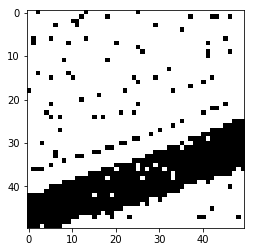

In [59]:
plt.imshow(y_pred.reshape((50,50)),cmap=cm.gray)

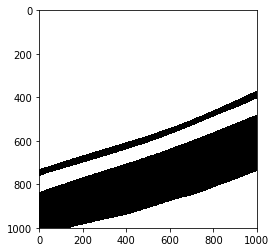

In [60]:
plt.imshow(img_lab,cmap=cm.gray)

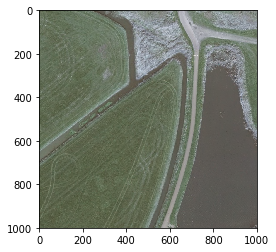

In [61]:
img_rgb = cv2.imread('water2.tif')
plt.imshow(img_rgb)
# Verdeel plaatje in delen van 20x20
z = 20
tegels_rgb = tegelen(img_rgb,z)

# Maak HOG aan voor elke tegel. Elke tegel krijgt een factor van 36
hogdata=[]
for tegel in tegels_rgb:
    hogdata.append(hog(tegel))

In [62]:
X_pred = normalizer.fit_transform(hogdata)
y_pred = clf.predict(X_pred)

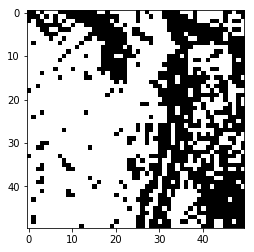

In [63]:
plt.imshow(y_pred.reshape((50,50)),cmap=cm.gray)